## Capstone 2 Machine Learning - Linear Regression

**Choice of Data:**<br>
I will be using the combined 2015 and 2016 data set for my machine learning model.  This will give me access to more observations to apply to the model, and will hopefully give me better results.  Two other combined datasets were created to test for the best kind of model.  The combined datasets include targets as a percent of Total Plan Selections (TPS) and All Features as a percent of TPS. <br><br>
**Choice of Method:**<br>
Linear Regression is the chosen model as I am seeking quantitative values of the metalic tiers for each county observation.  My EDA shows that not all of the features in the data will be helpful for regresion.  As such, I will try different models including Elastic Net, Ridge, Lasso and more.  Different scaling options will be tested on the model as well.  R^2 and Root Mean Squared Error will be our metrics for the models.

In [1]:
# Import Tools
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, HuberRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Make Plots Pretty
sns.set()

# Values Unscaled

,cfc,state,county,0-17,18-25,26-34,35-44,45-54,55-64,65+,...,platinum,gold,silver,bronze,catastrophic,new,active_renew,auto_renew,tps,Year
0,12109,FL,St. Johns County,1259.0,1093.0,1566.0,1684.0,2354.0,2963.0,41.0,...,1128.0,594.0,7209.0,1967.0,62.0,5875.0,3783.0,1302.0,10960.0,2015
1,10001,DE,Kent County,413.0,284.0,529.0,530.0,771.0,872.0,18.0,...,107.0,528.0,2136.0,629.0,17.0,1853.0,655.0,909.0,3417.0,2015
2,10003,DE,New Castle County,1964.0,1275.0,2487.0,2333.0,3288.0,3494.0,126.0,...,679.0,2406.0,8835.0,2943.0,104.0,7453.0,3340.0,4174.0,14967.0,2015
3,10005,DE,Sussex County,794.0,436.0,805.0,929.0,1453.0,2204.0,30.0,...,257.0,1144.0,4198.0,1032.0,20.0,3408.0,1531.0,1712.0,6651.0,2015
4,12001,FL,Alachua County,726.0,2161.0,2734.0,1867.0,2250.0,2940.0,41.0,...,1188.0,429.0,9169.0,1848.0,85.0,6443.0,4378.0,1898.0,12719.0,2015


In [3]:
# Create our X and y for the model with individual y's for each metallic tier.

# Our X Dropping the Metallic Tier Targets, String Data, and Categorical Year
X = df.drop(['cfc','state','county','platinum','gold','silver','bronze','catastrophic', 'Year'], axis=1).values

# Individual y's for Each Target Data
ycat = df.catastrophic.values
ycat = ycat.reshape(-1,1)

ybro = df.bronze.values
ybro = ybro.reshape(-1,1)

ysil = df.silver.values
ysil = ysil.reshape(-1,1)

ygold = df.gold.values
ygold = ygold.reshape(-1,1)

yplat = df.platinum.values
yplat = yplat.reshape(-1,1)

# Create List of Target Values and Names of Target Values
ys=[ycat, ybro, ysil, ygold, yplat]
ys_name = ['Catastrophic','Bronze','Silver','Gold','Platinum']

***
## Linear Regression - Unscaled

In [4]:
# Let's take a look at our predictive capabilites out of the box

# Instantiate Regressor and Nameplace
reg = LinearRegression()
place = 0

#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ys:
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=42)
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    score = reg.score(X_test, y_test)
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    print(ys_name[place], 'Score: {}'.format(score))
    cv_scores = cross_val_score(reg, X, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place = place+1

Catastrophic Root Mean Squared Error: 101.35513522757597
Catastrophic Score: 0.26155584930147957
Catastrophic Average 5-Fold R^2: 0.37692788352433615 

Bronze Root Mean Squared Error: 440.456484616362
Bronze Score: 0.9867952624702108
Bronze Average 5-Fold R^2: 0.9843763749503962 

Silver Root Mean Squared Error: 396.0262390216483
Silver Score: 0.9990152791700296
Silver Average 5-Fold R^2: 0.9990276367116137 

Gold Root Mean Squared Error: 205.2773926553915
Gold Score: 0.9527536802154588
Gold Average 5-Fold R^2: 0.9032524575621451 

Platinum Root Mean Squared Error: 242.4223240237867
Platinum Score: 0.24241795204508057
Platinum Average 5-Fold R^2: 0.04171794218998355 



***
## Ridge Unscaled


In [5]:
import warnings
warnings.filterwarnings('ignore')

# Time to tune the alpha of our Ridge Model.

#Instantiate Ridge Regressor and initiate name start point.
ridge = Ridge()
place = 0

# Create hyperparameter grid for alpha
alpha = [.0001,.001,.01,.1,1,10,100]
a_grid = {'alpha': alpha}

#Set up GridSearchCV object.
grid_cv = GridSearchCV(ridge, a_grid, cv=5)

# Iterate over metallic tiers and prine best alpha for each tier
for y in ys:
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=42)
    
    # Fit training data
    grid_cv.fit(X_train,y_train)
    
    # Predict on the test set and compute metrics
    y_pred = grid_cv.predict(X_test)
    r2 = grid_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print(ys_name[place],"Tuned Ridge alpha ratio: {}".format(grid_cv.best_params_))
    print(ys_name[place],"Tuned Ridge R^2: {}".format(r2))
    print(ys_name[place],"Tuned Ridge MSE: {}".format(mse),'\n')
    place+=1

Catastrophic Tuned Ridge alpha ratio: {'alpha': 100}
Catastrophic Tuned Ridge R^2: 0.2615378536997798
Catastrophic Tuned Ridge MSE: 10273.113782755612 

Bronze Tuned Ridge alpha ratio: {'alpha': 100}
Bronze Tuned Ridge R^2: 0.9867961665616776
Bronze Tuned Ridge MSE: 193988.63207179858 

Silver Tuned Ridge alpha ratio: {'alpha': 100}
Silver Tuned Ridge R^2: 0.9990152982324662
Silver Tuned Ridge MSE: 156833.74591364604 

Gold Tuned Ridge alpha ratio: {'alpha': 100}
Gold Tuned Ridge R^2: 0.9527549314037767
Gold Tuned Ridge MSE: 42137.69200542588 

Platinum Tuned Ridge alpha ratio: {'alpha': 0.0001}
Platinum Tuned Ridge R^2: 0.2424179520867561
Platinum Tuned Ridge MSE: 58768.5831818609 



In [6]:
# Initialize Alphas, and Nameplace
ridge_alphas=[100,100,100,100,0.0001]
place = 0

#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ys:
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=42)
    ridge = Ridge(alpha=ridge_alphas[place])
    ridge.fit(X_train, y_train)
    pred = ridge.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    cv_scores = cross_val_score(ridge, X, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place +=1

Catastrophic Root Mean Squared Error: 101.35637021300444
Catastrophic Average 5-Fold R^2: 0.37974699928346434 

Bronze Root Mean Squared Error: 440.44140594612423
Bronze Average 5-Fold R^2: 0.98436685760236 

Silver Root Mean Squared Error: 396.022405822759
Silver Average 5-Fold R^2: 0.9990279667131615 

Gold Root Mean Squared Error: 205.27467453494083
Gold Average 5-Fold R^2: 0.9026530098937041 

Platinum Root Mean Squared Error: 242.42232401711874
Platinum Average 5-Fold R^2: 0.034369230733370594 



***
## Lasso - Unscaled

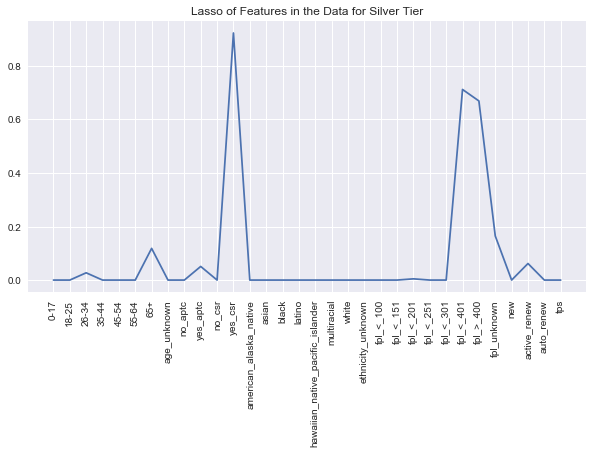

In [7]:
# Plot important features to predictive model using Lasso.  I'm starting with Silver Tier as it is the most selected tier.
X_df = df.drop(['cfc','state','county','platinum','gold','silver','bronze','catastrophic', 'Year'], axis=1)
cols = X_df.columns

# Instantiate and fit Lasso model and calculate the coeffecient.
lasso = Lasso(alpha=.5, normalize=True)
lasso.fit(X,ysil)
lasso_coef = lasso.coef_

# Plot the Lasso coeffecients for each feature.
fig, ax = plt.subplots(1,1, figsize=(10,5))
_ = ax.plot(range(len(cols)),lasso_coef)
_ = plt.xticks(range(len(cols)),cols.values, rotation=90)
_ = plt.title('Lasso of Features in the Data for Silver Tier')
plt.show()

As predicted in EDA and confirmed in plotting out the important features using Lasso, the following group of features play an important part in predicting metallic tier count:<br>
-   Age Group
-   Financial Aid Status
-   Income Level (based on percent above Federal Poverty Limit)
-   How Consumer Enrolled
***
Time to check and see if the same features are important for the other metallic tiers. 

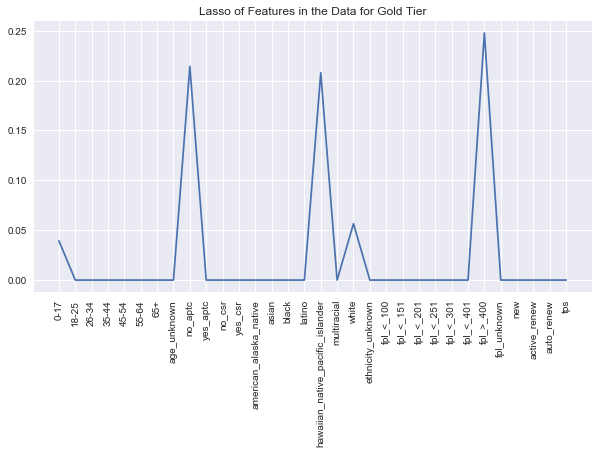

In [8]:
# Plot important features using Lasso on Gold target to see if the plot is similar to the silver plot.

# Instantiate and fit Lasso model and calculate the coeffecient.
lasso = Lasso(alpha=.4, normalize=True)
lasso.fit(X,ygold)
lasso_coef = lasso.coef_

# Plot the Lasso coeffecients for each feature.
fig, ax = plt.subplots(1,1, figsize=(10,5))
_ = ax.plot(range(len(cols)),lasso_coef)
_ = plt.xticks(range(len(cols)),cols.values, rotation=90)
_ = plt.title('Lasso of Features in the Data for Gold Tier')
plt.show()

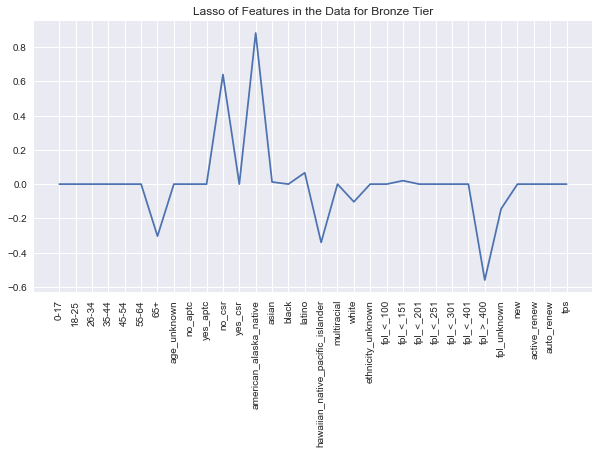

In [9]:
# Plot important features using Lasso on Bronze target.

# Instantiate and fit Lasso model and calculate the coeffecient.
lasso = Lasso(alpha=.4, normalize=True)
lasso.fit(X,ybro)
lasso_coef = lasso.coef_

# Plot the Lasso coeffecients for each feature.
fig, ax = plt.subplots(1,1, figsize=(10,5))
_ = ax.plot(range(len(cols)),lasso_coef)
_ = plt.xticks(range(len(cols)),cols.values, rotation=90)
_ = plt.title('Lasso of Features in the Data for Bronze Tier')
plt.show()

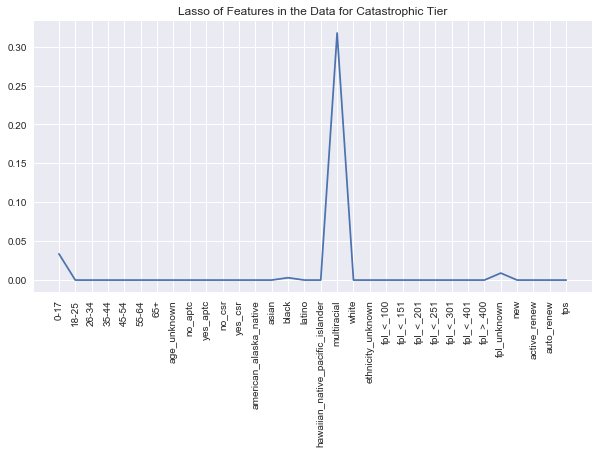

In [10]:
# Plot important features using Lasso on Catastrophic target.

# Instantiate and fit Lasso model and calculate the coeffecient.
lasso = Lasso(alpha=.4, normalize=True)
lasso.fit(X,ycat)
lasso_coef = lasso.coef_

# Plot the Lasso coeffecients for each feature.
fig, ax = plt.subplots(1,1, figsize=(10,5))
_ = ax.plot(range(len(cols)),lasso_coef)
_ = plt.xticks(range(len(cols)),cols.values, rotation=90)
_ = plt.title('Lasso of Features in the Data for Catastrophic Tier')
plt.show()

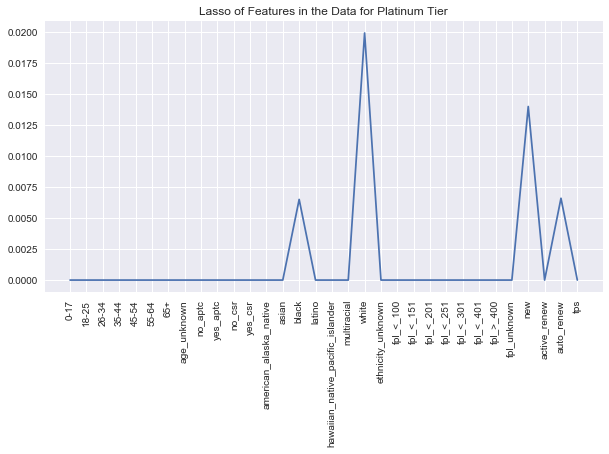

In [11]:
# Plot important features using Lasso on Platinum target.

# Instantiate and fit Lasso model and calculate the coeffecient.
lasso = Lasso(alpha=.4, normalize=True)
lasso.fit(X,yplat)
lasso_coef = lasso.coef_

# Plot the Lasso coeffecients for each feature.
fig, ax = plt.subplots(1,1, figsize=(10,5))
_ = ax.plot(range(len(cols)),lasso_coef)
_ = plt.xticks(range(len(cols)),cols.values, rotation=90)
_ = plt.title('Lasso of Features in the Data for Platinum Tier')
plt.show()

There are distinct and interesting feature differences for each tier.  Here is what I've found:
-  Catastrophic Tier: Young Age Group, Multiracial, Unknown Income Level
-  Bronze Tier:  Negative for Older Age Group, Lower Income, Various Enrollment Types and Ethnicities
-  Silver Tier:  Various Age, Financial Aid, Income, and Enrollment Types
-  Gold Tier:  Younger Age, No APTC, Various Ethnicities, High Income
-  Platinum Tier:  New and Automatic Enrollment Types, Black and White Ethnicities

In [12]:
# Time to tune the alpha of our Lasso Model.

#Instantiate Lasso Regressor and initiate place start point.
lasso = Lasso()
place = 0

# Create hyperparameter grid for alpha
alpha = [.0001,.001,.01,.1,1,10,100]
a_grid = {'alpha': alpha}

#Set up GridSearchCV object.
grid_cv = GridSearchCV(lasso, a_grid, cv=5)

# Iterate over metallic tiers and prine best alpha for each tier
for y in ys:
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=42)
    
    # Fit training data
    grid_cv.fit(X_train,y_train)
    
    # Predict on the test set and compute metrics
    y_pred = grid_cv.predict(X_test)
    r2 = grid_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print(ys_name[place],"Tuned Lasso alpha ratio: {}".format(grid_cv.best_params_))
    print(ys_name[place],"Tuned Lasso R^2: {}".format(r2))
    print(ys_name[place],"Tuned Lasso MSE: {}".format(mse),'\n')
    place+=1

Catastrophic Tuned Lasso alpha ratio: {'alpha': 0.0001}
Catastrophic Tuned Lasso R^2: 0.2750656158622846
Catastrophic Tuned Lasso MSE: 10084.922362765115 

Bronze Tuned Lasso alpha ratio: {'alpha': 100}
Bronze Tuned Lasso R^2: 0.9872627665308983
Bronze Tuned Lasso MSE: 187133.4191386239 

Silver Tuned Lasso alpha ratio: {'alpha': 100}
Silver Tuned Lasso R^2: 0.9993309172221885
Silver Tuned Lasso MSE: 106565.01473873168 

Gold Tuned Lasso alpha ratio: {'alpha': 100}
Gold Tuned Lasso R^2: 0.9486046699876299
Gold Tuned Lasso MSE: 45839.29393959213 

Platinum Tuned Lasso alpha ratio: {'alpha': 100}
Platinum Tuned Lasso R^2: 0.21679599681524764
Platinum Tuned Lasso MSE: 60756.17781112012 



In [13]:
# Initialize Alphas, and Nameplace
lasso_alphas=[.0001,100,100,100,100]
place = 0

#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ys:
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=42)
    lasso = Lasso(alpha=lasso_alphas[place])
    lasso.fit(X_train, y_train)
    pred = lasso.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    cv_scores = cross_val_score(lasso, X, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place +=1

Catastrophic Root Mean Squared Error: 100.42371414544034
Catastrophic Average 5-Fold R^2: 0.40812799573230885 

Bronze Root Mean Squared Error: 432.58920367783554
Bronze Average 5-Fold R^2: 0.9846291189828854 

Silver Root Mean Squared Error: 326.44297318020443
Silver Average 5-Fold R^2: 0.999032394559574 

Gold Root Mean Squared Error: 214.101130168881
Gold Average 5-Fold R^2: 0.9026075673594584 

Platinum Root Mean Squared Error: 246.48768287912506
Platinum Average 5-Fold R^2: 0.18690755134160866 



In [14]:
# Initialize starting place.
place = 0
#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ys:
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=42)
    
    # Scaling the data may help as variance is very high within the data.
    steps = [('scaler', StandardScaler()),('lasso', Lasso(alpha=lasso_alphas[place]))]
    # Create Pipeline and initialize starting place.
    pipe = Pipeline(steps)
    # Fit pipeline and calculate metrics. 
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    cv_scores = cross_val_score(pipe, X, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place +=1


Catastrophic Root Mean Squared Error: 100.41959793749817
Catastrophic Average 5-Fold R^2: 0.40818364696316856 

Bronze Root Mean Squared Error: 660.6630599438158
Bronze Average 5-Fold R^2: 0.9591999679061051 

Silver Root Mean Squared Error: 307.26281237398626
Silver Average 5-Fold R^2: 0.998765174423003 

Gold Root Mean Squared Error: 249.8378300788223
Gold Average 5-Fold R^2: 0.9010608234621416 

Platinum Root Mean Squared Error: 196.62913589665277
Platinum Average 5-Fold R^2: 0.3095282200596486 



It does not appear as though Lasso will be a useful model either.
***
## ElasticNet - Unscaled

In [17]:
# Time to tune the l1 ratio of our ElasticNet Model.

# Instantiate ElasticNet Regressor and initiate name start point.
enet = ElasticNet()
place = 0

# Create hyperparameter grid for alpha
l1_space = np.linspace(-1,1,30)
grid = {'l1_ratio': l1_space}

#Set up GridSearchCV object.
grid_cv = GridSearchCV(enet, grid, cv=5)

# Iterate over metallic tiers and prine best alpha for each tier
for y in ys:
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=42)
    
    # Fit training data
    grid_cv.fit(X_train,y_train)
    
    # Predict on the test set and compute metrics
    y_pred = grid_cv.predict(X_test)
    r2 = grid_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print(ys_name[place],"Tuned ElasticNet l1 ratio: {}".format(grid_cv.best_params_))
    print(ys_name[place],"Tuned ElasticNet R^2: {}".format(r2))
    print(ys_name[place],"Tuned ElasticNet MSE: {}".format(mse),'\n')
    place+=1

Catastrophic Tuned ElasticNet l1 ratio: {'l1_ratio': -1.0}
Catastrophic Tuned ElasticNet R^2: 0.27462528324821367
Catastrophic Tuned ElasticNet MSE: 10091.048048515257 

Bronze Tuned ElasticNet l1 ratio: {'l1_ratio': -1.0}
Bronze Tuned ElasticNet R^2: 0.9863183215199286
Bronze Tuned ElasticNet MSE: 201009.05583162373 

Silver Tuned ElasticNet l1 ratio: {'l1_ratio': -1.0}
Silver Tuned ElasticNet R^2: 0.999321536098446
Silver Tuned ElasticNet MSE: 108059.14913142152 

Gold Tuned ElasticNet l1 ratio: {'l1_ratio': -1.0}
Gold Tuned ElasticNet R^2: 0.9471541709083171
Gold Tuned ElasticNet MSE: 47132.988398596724 

Platinum Tuned ElasticNet l1 ratio: {'l1_ratio': -1.0}
Platinum Tuned ElasticNet R^2: 0.23311337355355322
Platinum Tuned ElasticNet MSE: 59490.375493343054 



In [18]:
# Initialize Alphas, Model, and Nameplace
enet_l1=[-1,-1,-1,-1,-1]
place = 0

#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ys:
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=42)
    enet = ElasticNet(l1_ratio= enet_l1[place])
    enet.fit(X_train, y_train)
    pred = enet.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    cv_scores = cross_val_score(enet, X, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')

    place +=1

Catastrophic Root Mean Squared Error: 100.45420871479331
Catastrophic Average 5-Fold R^2: 0.4110486605402518 

Bronze Root Mean Squared Error: 448.3403348257033
Bronze Average 5-Fold R^2: 0.984393122185747 

Silver Root Mean Squared Error: 328.7235147223598
Silver Average 5-Fold R^2: 0.9990275711539962 

Gold Root Mean Squared Error: 217.10133209770208
Gold Average 5-Fold R^2: 0.8952090610960909 

Platinum Root Mean Squared Error: 243.90648923991967
Platinum Average 5-Fold R^2: 0.11765477317572019 



***
## Huber - Unscaled

In [7]:
# Tuning the alpha of the Huber Regresspr Model.

#Instantiate Huber Regressor and initiate place start point.
huber = HuberRegressor()
place = 0

# Create hyperparameter grid for alpha
alpha = [.0001,.001,.01,.1,1,10,100]
a_grid = {'alpha': alpha}

#Set up GridSearchCV object.
grid_cv = GridSearchCV(huber, a_grid, cv=5)

# Iterate over metallic tiers and prine best alpha for each tier
for y in ys:
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=42)
    
    # Fit training data
    grid_cv.fit(X_train,y_train)
    
    # Predict on the test set and compute metrics
    y_pred = grid_cv.predict(X_test)
    r2 = grid_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print(ys_name[place],"Tuned Huber alpha ratio: {}".format(grid_cv.best_params_))
    print(ys_name[place],"Tuned Huber R^2: {}".format(r2))
    print(ys_name[place],"Tuned Huber MSE: {}".format(mse),'\n')
    place+=1

Catastrophic Tuned Huber alpha ratio: {'alpha': 0.0001}
Catastrophic Tuned Huber R^2: 0.18955625786819974
Catastrophic Tuned Huber MSE: 11274.48552258954 

Bronze Tuned Huber alpha ratio: {'alpha': 10}
Bronze Tuned Huber R^2: 0.9917086673938568
Bronze Tuned Huber MSE: 121814.94698727313 

Silver Tuned Huber alpha ratio: {'alpha': 0.01}
Silver Tuned Huber R^2: 0.9993385745057756
Silver Tuned Huber MSE: 105345.43688471787 

Gold Tuned Huber alpha ratio: {'alpha': 0.01}
Gold Tuned Huber R^2: 0.9557701991952531
Gold Tuned Huber MSE: 39448.38644854341 

Platinum Tuned Huber alpha ratio: {'alpha': 0.001}
Platinum Tuned Huber R^2: 0.4851776078245345
Platinum Tuned Huber MSE: 39936.77339871868 



In [20]:
# Initialize Alphas, and Nameplace
huber_alphas=[.0001,10,.01,.01,.001]
place = 0

#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ys:
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=42)
    huber = HuberRegressor(alpha=huber_alphas[place],)
    huber.fit(X_train, y_train)
    pred = huber.predict(X_test)
    score = huber.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    print(ys_name[place], 'Score: {}'.format(score))
    cv_scores = cross_val_score(huber, X, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place +=1

Catastrophic Root Mean Squared Error: 106.18138030083024
Catastrophic Score: 0.18955625786819974
Catastrophic Average 5-Fold R^2: 0.5951471090000697 

Bronze Root Mean Squared Error: 349.01998078515953
Bronze Score: 0.9917086673938568
Bronze Average 5-Fold R^2: 0.9860237267213519 

Silver Root Mean Squared Error: 324.56961793229794
Silver Score: 0.9993385745057756
Silver Average 5-Fold R^2: 0.9989523140860272 

Gold Root Mean Squared Error: 198.6161787180073
Gold Score: 0.9557701991952531
Gold Average 5-Fold R^2: 0.9064597556551283 

Platinum Root Mean Squared Error: 199.8418709848331
Platinum Score: 0.4851776078245345
Platinum Average 5-Fold R^2: 0.43620790004043464 



In [21]:
# Initialize starting place for a scaled Huber Regressor
place = 0
#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ys:
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=42)
    
    # Scaling the data may help as variance is very high within the data.
    steps = [('scaler', StandardScaler()),('huber', HuberRegressor(alpha=huber_alphas[place]))]
    # Create Pipeline and initialize starting place.
    pipe = Pipeline(steps)
    # Fit pipeline and calculate metrics. 
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    score = pipe.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    print(ys_name[place], 'Score: {}'.format(score))
    cv_scores = cross_val_score(pipe, X, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place +=1


Catastrophic Root Mean Squared Error: 105.37262252130427
Catastrophic Score: 0.20185514619577238
Catastrophic Average 5-Fold R^2: 0.5531423384307141 

Bronze Root Mean Squared Error: 1765.399940522252
Bronze Score: 0.7878661510421018
Bronze Average 5-Fold R^2: 0.8047104586493136 

Silver Root Mean Squared Error: 307.9728089504467
Silver Score: 0.9994044887775054
Silver Average 5-Fold R^2: 0.9989721173003623 

Gold Root Mean Squared Error: 208.1143781287514
Gold Score: 0.951438744024792
Gold Average 5-Fold R^2: 0.9009968530793835 

Platinum Root Mean Squared Error: 213.66628568978024
Platinum Score: 0.4114864656151856
Platinum Average 5-Fold R^2: 0.38932615443460217 



## Gradient Boosting - Unscaled

In [8]:
# Initialize nameplace
place = 0

# Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ys:
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=42)
    grad = GradientBoostingRegressor(n_estimators=300, max_depth=2, random_state=42)
    grad.fit(X_train, y_train)
    pred = grad.predict(X_test)
    score = grad.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    print(ys_name[place], 'Score: {}'.format(score))
    cv_scores = cross_val_score(huber, X, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place +=1

Catastrophic Root Mean Squared Error: 85.14771167816247
Catastrophic Score: 0.47883876839650336
Catastrophic Average 5-Fold R^2: 0.5951471090000697 

Bronze Root Mean Squared Error: 827.1416829281717
Bronze Score: 0.9534324305419857
Bronze Average 5-Fold R^2: 0.9869672061688934 

Silver Root Mean Squared Error: 1612.3638598013952
Silver Score: 0.9836773258002751
Silver Average 5-Fold R^2: 0.9989420181597474 

Gold Root Mean Squared Error: 332.90553241066544
Gold Score: 0.8757410256489686
Gold Average 5-Fold R^2: 0.9044673965043384 

Platinum Root Mean Squared Error: 216.13640509385758
Platinum Score: 0.39780062331073
Platinum Average 5-Fold R^2: 0.4619554928064966 



The best model in this selection overall is the hyperparameter tuned **Huber Regressor - Unscaled**.
***
It appears that having our model predict raw counts of data is working well for Gold, Silver, and Bronze plans, but not going working well for Platinum and Catastrophic plans.  To answer this issue I will return to my data set and calculate the target counts into percents of each observation's total plan selection.  Hopefully this will create more predictability in the dataset.
***
# Tiers Scaled to Percent of TPS

In [22]:
dfp = pd.read_csv('Combo_Percents.csv')
dfp.drop('Unnamed: 0', axis=1, inplace=True)
dfp.head()

,cfc,state,county,0-17,18-25,26-34,35-44,45-54,55-64,65+,...,platinum,gold,silver,bronze,catastrophic,new,active_renew,auto_renew,tps,Year
0,12109,FL,St. Johns County,1259.0,1093.0,1566.0,1684.0,2354.0,2963.0,41.0,...,0.10,0.05,0.66,0.18,0.01,5875.0,3783.0,1302.0,10960.0,2015
1,10001,DE,Kent County,413.0,284.0,529.0,530.0,771.0,872.0,18.0,...,0.03,0.15,0.63,0.18,0.00,1853.0,655.0,909.0,3417.0,2015
2,10003,DE,New Castle County,1964.0,1275.0,2487.0,2333.0,3288.0,3494.0,126.0,...,0.05,0.16,0.59,0.20,0.01,7453.0,3340.0,4174.0,14967.0,2015
3,10005,DE,Sussex County,794.0,436.0,805.0,929.0,1453.0,2204.0,30.0,...,0.04,0.17,0.63,0.16,0.00,3408.0,1531.0,1712.0,6651.0,2015
4,12001,FL,Alachua County,726.0,2161.0,2734.0,1867.0,2250.0,2940.0,41.0,...,0.09,0.03,0.72,0.15,0.01,6443.0,4378.0,1898.0,12719.0,2015


In [23]:
# Create the X and y for the model with individual y's for each metallic tier.

# Our X Dropping the Metallic Tier Targets, String Data, and Categorical Year
Xp = dfp.drop(['cfc','state','county','platinum','gold','silver','bronze','catastrophic', 'Year'],
              axis=1).values

# Individual y's for Each Target Data
ycatp = dfp.catastrophic.values
ycatp = ycatp.reshape(-1,1)

ybrop = dfp.bronze.values
ybrop = ybrop.reshape(-1,1)

ysilp = dfp.silver.values
ysilp = ysilp.reshape(-1,1)

ygoldp = dfp.gold.values
ygoldp = ygoldp.reshape(-1,1)

yplatp = dfp.platinum.values
yplatp = yplatp.reshape(-1,1)

# Create List of Target Values for Percent Data
ysp=[ycatp, ybrop, ysilp, ygoldp, yplatp]

***
## Linear Regression - Targets by Percent

In [24]:
# Test out of the box model using percents of whole over raw counts.

# Instantiate Regressor and Nameplace
reg = LinearRegression()
place = 0

#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ysp:
    X_train, X_test, y_train, y_test = train_test_split(Xp,y, test_size=.3, random_state=42)
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    cv_scores = cross_val_score(reg, Xp, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place += 1

Catastrophic Root Mean Squared Error: 0.007400627882541825
Catastrophic Average 5-Fold R^2: -0.24785604065671274 

Bronze Root Mean Squared Error: 0.09365161049079318
Bronze Average 5-Fold R^2: -0.0905634346929111 

Silver Root Mean Squared Error: 0.09452794684672844
Silver Average 5-Fold R^2: -0.10616253346053099 

Gold Root Mean Squared Error: 0.05673160743187787
Gold Average 5-Fold R^2: -0.04303193261027296 

Platinum Root Mean Squared Error: 0.016433861412031545
Platinum Average 5-Fold R^2: -0.6251861738800907 



***
## Ridge - Targets by Percent 

In [27]:
#Instantiate Ridge Regressor and initiate name start point.
ridge = Ridge()
place = 0

# Create hyperparameter grid for alpha
alpha = [.0001,.001,.01,.1,1,10,100]
a_grid = {'alpha': alpha}

#Set up GridSearchCV object.
grid_cv = GridSearchCV(ridge, a_grid, cv=5)

# Iterate over metallic tiers and prine best alpha for each tier
for y in ysp:
    X_train, X_test, y_train, y_test = train_test_split(Xp,y, test_size=.3, random_state=42)
    
    # Fit training data
    grid_cv.fit(X_train,y_train)
    
    # Predict on the test set and compute metrics
    y_pred = grid_cv.predict(X_test)
    r2 = grid_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print(ys_name[place],"Tuned Ridge alpha ratio: {}".format(grid_cv.best_params_))
    print(ys_name[place],"Tuned Ridge R^2: {}".format(r2))
    print(ys_name[place],"Tuned Ridge MSE: {}".format(mse),'\n')
    place+=1

Catastrophic Tuned Ridge alpha ratio: {'alpha': 0.0001}
Catastrophic Tuned Ridge R^2: -0.08244686903271825
Catastrophic Tuned Ridge MSE: 5.495009693971975e-05 

Bronze Tuned Ridge alpha ratio: {'alpha': 100}
Bronze Tuned Ridge R^2: 0.10218857216693
Bronze Tuned Ridge MSE: 0.008770414613681938 

Silver Tuned Ridge alpha ratio: {'alpha': 100}
Silver Tuned Ridge R^2: 0.08738347121358736
Silver Tuned Ridge MSE: 0.008968517690297093 

Gold Tuned Ridge alpha ratio: {'alpha': 0.0001}
Gold Tuned Ridge R^2: -0.03153638602891884
Gold Tuned Ridge MSE: 0.0032299879911583613 

Platinum Tuned Ridge alpha ratio: {'alpha': 100}
Platinum Tuned Ridge R^2: 0.016080726944169843
Platinum Tuned Ridge MSE: 0.00027001344025212614 



In [28]:
# Initialize Alphas, and Nameplace
ridge_alphas=[.0001,100,100,.0001,100]
place = 0

#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ysp:
    X_train, X_test, y_train, y_test = train_test_split(Xp,y, test_size=.3, random_state=42)
    ridge = Ridge(alpha=ridge_alphas[place])
    ridge.fit(X_train, y_train)
    pred = ridge.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    cv_scores = cross_val_score(ridge, Xp, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place +=1

Catastrophic Root Mean Squared Error: 0.007412833259943174
Catastrophic Average 5-Fold R^2: -0.24702719423804204 

Bronze Root Mean Squared Error: 0.09365049179626307
Bronze Average 5-Fold R^2: -0.09014564996142949 

Silver Root Mean Squared Error: 0.09470225810558633
Silver Average 5-Fold R^2: -0.10598317396896469 

Gold Root Mean Squared Error: 0.056832983303345616
Gold Average 5-Fold R^2: -0.04693259993284611 

Platinum Root Mean Squared Error: 0.016432085693913787
Platinum Average 5-Fold R^2: -0.5617753710851605 



***
## Lasso - Targets by Percent

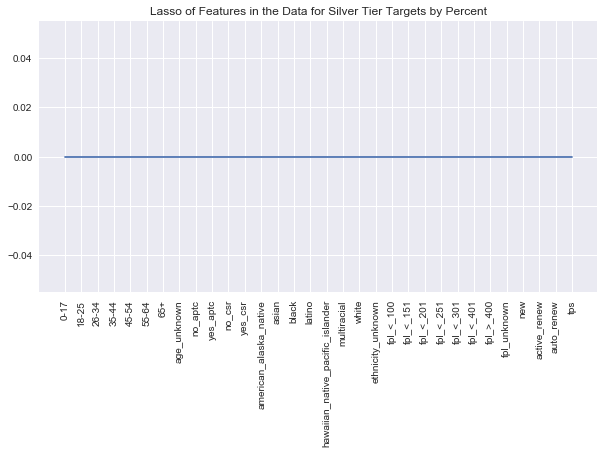

In [29]:
# Plot important features to predictive model using Lasso.
X_dfp = dfp.drop(['cfc','state','county','platinum','gold','silver','bronze','catastrophic', 'Year'], axis=1)
cols = X_dfp.columns

# Instantiate and fit Lasso model and calculate the coeffecient.
lasso = Lasso(alpha=.5, normalize=True)
lasso.fit(Xp,ysilp)
lasso_coef = lasso.coef_

# Plot the Lasso coeffecients for each feature.
fig, ax = plt.subplots(1,1, figsize=(10,5))
_ = ax.plot(range(len(cols)),lasso_coef)
_ = plt.xticks(range(len(cols)),cols.values, rotation=90)
_ = plt.title('Lasso of Features in the Data for Silver Tier Targets by Percent')
plt.show()

In [30]:
# Time to tune the alpha of our Lasso Model.

#Instantiate Lasso Regressor and initiate name start point.
lasso = Lasso()
place = 0

# Create hyperparameter grid for alpha
alpha = [.0001,.001,.01,.1,1,10,100]
a_grid = {'alpha': alpha}

#Set up GridSearchCV object.
grid_cv = GridSearchCV(lasso, a_grid, cv=5)

# Iterate over metallic tiers and prine best alpha for each tier
for y in ysp:
    X_train, X_test, y_train, y_test = train_test_split(Xp,y, test_size=.3, random_state=42)
    
    # Fit training data
    grid_cv.fit(X_train,y_train)
    
    # Predict on the test set and compute metrics
    y_pred = grid_cv.predict(X_test)
    r2 = grid_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print(ys_name[place],"Tuned Lasso alpha ratio: {}".format(grid_cv.best_params_))
    print(ys_name[place],"Tuned Lasso R^2: {}".format(r2))
    print(ys_name[place],"Tuned Lasso MSE: {}".format(mse),'\n')
    place+=1

Catastrophic Tuned Lasso alpha ratio: {'alpha': 1}
Catastrophic Tuned Lasso R^2: 0.057904937480768186
Catastrophic Tuned Lasso MSE: 4.7825178762005704e-05 

Bronze Tuned Lasso alpha ratio: {'alpha': 1}
Bronze Tuned Lasso R^2: 0.0584281627171489
Bronze Tuned Lasso MSE: 0.009197895176571836 

Silver Tuned Lasso alpha ratio: {'alpha': 1}
Silver Tuned Lasso R^2: 0.07254644629309182
Silver Tuned Lasso MSE: 0.009114324955751504 

Gold Tuned Lasso alpha ratio: {'alpha': 1}
Gold Tuned Lasso R^2: 0.020108513945008677
Gold Tuned Lasso MSE: 0.0030682754146756893 

Platinum Tuned Lasso alpha ratio: {'alpha': 0.01}
Platinum Tuned Lasso R^2: 0.016485150248427005
Platinum Tuned Lasso MSE: 0.00026990245581398067 



In [31]:
# Initialize Alphas, and Nameplace
lasso_alphas=[1,1,1,1,.01]
place = 0

#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ysp:
    X_train, X_test, y_train, y_test = train_test_split(Xp,y, test_size=.3, random_state=42)
    lasso = Lasso(alpha=lasso_alphas[place])
    lasso.fit(X_train, y_train)
    pred = lasso.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    cv_scores = cross_val_score(lasso, Xp, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place +=1

Catastrophic Root Mean Squared Error: 0.006915575085414495
Catastrophic Average 5-Fold R^2: 0.032647012350719005 

Bronze Root Mean Squared Error: 0.09590565768802087
Bronze Average 5-Fold R^2: 0.029110066399375502 

Silver Root Mean Squared Error: 0.09546897378599764
Silver Average 5-Fold R^2: 0.004169461649293771 

Gold Root Mean Squared Error: 0.055392015802601814
Gold Average 5-Fold R^2: 0.015947636368452044 

Platinum Root Mean Squared Error: 0.01642870828196729
Platinum Average 5-Fold R^2: -0.5511319852053682 



In [32]:
# Initialize starting place.
place = 0
#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ysp:
    X_train, X_test, y_train, y_test = train_test_split(Xp,y, test_size=.3, random_state=42)
    
    # Scaling the data may help as variance is very high within the data.
    steps = [('scaler', StandardScaler()),('lasso', Lasso(alpha=lasso_alphas[place]))]
    # Create Pipeline and initialize starting place.
    pipe = Pipeline(steps)
    # Fit pipeline and calculate metrics. 
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    cv_scores = cross_val_score(pipe, Xp, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place +=1

Catastrophic Root Mean Squared Error: 0.007129091070960871
Catastrophic Average 5-Fold R^2: -0.02410017603405108 

Bronze Root Mean Squared Error: 0.09901230444225553
Bronze Average 5-Fold R^2: -0.01188822846085973 

Silver Root Mean Squared Error: 0.0992505761091123
Silver Average 5-Fold R^2: -0.04316785679304784 

Gold Root Mean Squared Error: 0.055958873060750196
Gold Average 5-Fold R^2: -0.008709568329757911 

Platinum Root Mean Squared Error: 0.016568541077409436
Platinum Average 5-Fold R^2: -0.4399385234516765 



***
## ElasticNet - Targets by Percent

In [33]:
# Time to tune the l1 ratio of our ElasticNet Model.

# Instantiate ElasticNet Regressor and initiate name start point.
enet = ElasticNet()
place = 0

# Create hyperparameter grid for alpha
l1_space = np.linspace(-1,1.5,30)
grid = {'l1_ratio': l1_space}

#Set up GridSearchCV object.
grid_cv = GridSearchCV(enet, grid, cv=5)

# Iterate over metallic tiers and prine best alpha for each tier
for y in ysp:
    X_train, X_test, y_train, y_test = train_test_split(Xp,y, test_size=.3, random_state=42)
    
    # Fit training data
    grid_cv.fit(X_train,y_train)
    
    # Predict on the test set and compute metrics
    y_pred = grid_cv.predict(X_test)
    r2 = grid_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print(ys_name[place],"Tuned ElasticNet l1 ratio: {}".format(grid_cv.best_params_))
    print(ys_name[place],"Tuned ElasticNet R^2: {}".format(r2))
    print(ys_name[place],"Tuned ElasticNet MSE: {}".format(mse),'\n')
    place+=1

Catastrophic Tuned ElasticNet l1 ratio: {'l1_ratio': 0.72413793103448287}
Catastrophic Tuned ElasticNet R^2: 0.06153763061441365
Catastrophic Tuned ElasticNet MSE: 4.764076616351535e-05 

Bronze Tuned ElasticNet l1 ratio: {'l1_ratio': 1.5}
Bronze Tuned ElasticNet R^2: 0.05396893994995445
Bronze Tuned ElasticNet MSE: 0.009241455807803117 

Silver Tuned ElasticNet l1 ratio: {'l1_ratio': 1.5}
Silver Tuned ElasticNet R^2: 0.06936256162736432
Silver Tuned ElasticNet MSE: 0.009145613810432248 

Gold Tuned ElasticNet l1 ratio: {'l1_ratio': 1.5}
Gold Tuned ElasticNet R^2: 0.020001042180059714
Gold Tuned ElasticNet MSE: 0.0030686119345647357 

Platinum Tuned ElasticNet l1 ratio: {'l1_ratio': 0.034482758620689724}
Platinum Tuned ElasticNet R^2: 0.020861357168609262
Platinum Tuned ElasticNet MSE: 0.0002687015090309141 



In [34]:
# Initialize Alphas, Model, and Nameplace
enet_l1= [.72414,1.5,1.5,1.5,.03448]
place = 0

#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ysp:
    X_train, X_test, y_train, y_test = train_test_split(Xp,y, test_size=.3, random_state=42)
    enet = ElasticNet(l1_ratio= enet_l1[place])
    enet.fit(X_train, y_train)
    pred = enet.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    cv_scores = cross_val_score(enet, Xp, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place +=1

Catastrophic Root Mean Squared Error: 0.006902229164162708
Catastrophic Average 5-Fold R^2: 0.034088642689225734 

Bronze Root Mean Squared Error: 0.09613249090605692
Bronze Average 5-Fold R^2: 0.03479293223967446 

Silver Root Mean Squared Error: 0.0956327026201406
Silver Average 5-Fold R^2: 0.010422263510093099 

Gold Root Mean Squared Error: 0.05539505334021022
Gold Average 5-Fold R^2: 0.015188137886481323 

Platinum Root Mean Squared Error: 0.016392117150334447
Platinum Average 5-Fold R^2: -0.4531393381484815 



***
## Huber - Targets by Percent

In [35]:
# Tuning the alpha of the Huber Regresspr Model.

#Instantiate Huber Regressor and initiate place start point.
huber = HuberRegressor()
place = 0

# Create hyperparameter grid for alpha
alpha = [.0001,.001,.01,.1,1,10,100]
a_grid = {'alpha': alpha}

#Set up GridSearchCV object.
grid_cv = GridSearchCV(huber, a_grid, cv=5)

# Iterate over metallic tiers and prine best alpha for each tier
for y in ysp:
    X_train, X_test, y_train, y_test = train_test_split(Xp,y, test_size=.3, random_state=42)
    
    # Fit training data
    grid_cv.fit(X_train,y_train)
    
    # Predict on the test set and compute metrics
    y_pred = grid_cv.predict(X_test)
    r2 = grid_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print(ys_name[place],"Tuned Huber alpha ratio: {}".format(grid_cv.best_params_))
    print(ys_name[place],"Tuned Huber R^2: {}".format(r2))
    print(ys_name[place],"Tuned Huber MSE: {}".format(mse),'\n')
    place+=1

Catastrophic Tuned Huber alpha ratio: {'alpha': 10}
Catastrophic Tuned Huber R^2: -37.293871701780255
Catastrophic Tuned Huber MSE: 0.0019439771340374328 

Bronze Tuned Huber alpha ratio: {'alpha': 0.01}
Bronze Tuned Huber R^2: -4.487091409265188
Bronze Tuned Huber MSE: 0.053601530555897225 

Silver Tuned Huber alpha ratio: {'alpha': 0.0001}
Silver Tuned Huber R^2: -40.22716178935762
Silver Tuned Huber MSE: 0.4051499377512689 

Gold Tuned Huber alpha ratio: {'alpha': 1}
Gold Tuned Huber R^2: -0.49313299883143724
Gold Tuned Huber MSE: 0.004675357768031857 

Platinum Tuned Huber alpha ratio: {'alpha': 0.1}
Platinum Tuned Huber R^2: -0.69129473242059
Platinum Tuned Huber MSE: 0.00046413595270154836 



In [36]:
# Initialize Alphas, and Nameplace
huber_alphas=[10,.01,.0001,1,.1]
place = 0

#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ysp:
    X_train, X_test, y_train, y_test = train_test_split(Xp,y, test_size=.3, random_state=42)
    huber = HuberRegressor(alpha=huber_alphas[place])
    huber.fit(X_train, y_train)
    pred = huber.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    score = huber.score(X_test, y_test)
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    print(ys_name[place], 'Score: {}'.format(score))
    cv_scores = cross_val_score(huber, Xp, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place +=1

Catastrophic Root Mean Squared Error: 0.04409055606405336
Catastrophic Score: -37.293871701780255
Catastrophic Average 5-Fold R^2: -52.92595605057797 

Bronze Root Mean Squared Error: 0.2315200435294906
Bronze Score: -4.487091409265188
Bronze Average 5-Fold R^2: -5.19965490095849 

Silver Root Mean Squared Error: 0.6365138943897996
Silver Score: -40.22716178935762
Silver Average 5-Fold R^2: -44.16081700531485 

Gold Root Mean Squared Error: 0.06837658786479373
Gold Score: -0.49313299883143724
Gold Average 5-Fold R^2: -0.7713864851307106 

Platinum Root Mean Squared Error: 0.021543814720275247
Platinum Score: -0.69129473242059
Platinum Average 5-Fold R^2: -9.967674010366206 



In [37]:
# Initialize starting place for a scaled Huber Regressor
place = 0
#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ysp:
    X_train, X_test, y_train, y_test = train_test_split(Xp,y, test_size=.3, random_state=42)
    
    # Scaling the data may help as variance is very high within the data.
    steps = [('scaler', StandardScaler()),('huber', HuberRegressor(alpha=huber_alphas[place]))]
    # Create Pipeline and initialize starting place.
    pipe = Pipeline(steps)
    # Fit pipeline and calculate metrics. 
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    cv_scores = cross_val_score(pipe, Xp, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place +=1


Catastrophic Root Mean Squared Error: 0.008805528778260734
Catastrophic Average 5-Fold R^2: -0.21892117783462628 

Bronze Root Mean Squared Error: 0.09465062314359443
Bronze Average 5-Fold R^2: -0.18435049885401367 

Silver Root Mean Squared Error: 0.09551323325252033
Silver Average 5-Fold R^2: -0.23774903155733865 

Gold Root Mean Squared Error: 0.05757080239440115
Gold Average 5-Fold R^2: -0.08976937396824688 

Platinum Root Mean Squared Error: 0.016902023816882675
Platinum Average 5-Fold R^2: -0.1245695234561393 



None of the models in this section come close to the R^2 of the Raw Counts Models.
***
While the RMSE is much smaller, none of the R^2s came close to those for the unscaled data.  One more test is to scale all data the same way the target values were scaled.  (Dividing by the observations total plan selection.  Let's see how all of this
***
# Features Scaled to Percent of TPS

In [38]:
dfap = pd.read_csv('Combo_All_Percents.csv')
dfap.drop('Unnamed: 0', axis=1, inplace=True)
dfap.head()

,cfc,state,county,0-17,18-25,26-34,35-44,45-54,55-64,65+,...,platinum,gold,silver,bronze,catastrophic,new,active_renew,auto_renew,tps,Year
0,12109,FL,St. Johns County,0.1149,0.0997,0.1429,0.1536,0.2148,0.2703,0.0037,...,0.10,0.05,0.66,0.18,0.01,0.5360,0.3452,0.1188,10960.0,2015
1,10001,DE,Kent County,0.1209,0.0831,0.1548,0.1551,0.2256,0.2552,0.0053,...,0.03,0.15,0.63,0.18,0.00,0.5423,0.1917,0.2660,3417.0,2015
2,10003,DE,New Castle County,0.1312,0.0852,0.1662,0.1559,0.2197,0.2334,0.0084,...,0.05,0.16,0.59,0.20,0.01,0.4980,0.2232,0.2789,14967.0,2015
3,10005,DE,Sussex County,0.1194,0.0656,0.1210,0.1397,0.2185,0.3314,0.0045,...,0.04,0.17,0.63,0.16,0.00,0.5124,0.2302,0.2574,6651.0,2015
4,12001,FL,Alachua County,0.0571,0.1699,0.2150,0.1468,0.1769,0.2312,0.0032,...,0.09,0.03,0.72,0.15,0.01,0.5066,0.3442,0.1492,12719.0,2015


In [39]:
# Create the X and y for the model with individual y's for each metallic tier.

# Our X Dropping the Metallic Tier Targets, String Data, and Categorical Year
Xap = dfap.drop(['cfc','state','county','platinum','gold','silver','bronze','catastrophic', 'Year'],
              axis=1).values

# Individual y's for Each Target Data
ycatap = dfap.catastrophic.values
ycatap = ycatap.reshape(-1,1)

ybroap = dfap.bronze.values
ybroap = ybroap.reshape(-1,1)

ysilap = dfap.silver.values
ysilap = ysilap.reshape(-1,1)

ygoldap = dfap.gold.values
ygoldap = ygoldap.reshape(-1,1)

yplatap = dfap.platinum.values
yplatap = yplatap.reshape(-1,1)

# Create List of Target Values for Percent Data
ysap=[ycatap, ybroap, ysilap, ygoldap, yplatap]

***
## Linear Regression - All by Percent

In [40]:
# Test out of the box model using percents of whole over raw counts.

# Instantiate Regressor and Nameplace
reg = LinearRegression()
place = 0

#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ysap:
    X_train, X_test, y_train, y_test = train_test_split(Xap,y, test_size=.3, random_state=42)
    reg.fit(X_train, y_train)
    pred = reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    cv_scores = cross_val_score(reg, Xap, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place += 1

Catastrophic Root Mean Squared Error: 0.00604427643453169
Catastrophic Average 5-Fold R^2: 0.19488512328583235 

Bronze Root Mean Squared Error: 0.06273118050995803
Bronze Average 5-Fold R^2: 0.5801885979260296 

Silver Root Mean Squared Error: 0.03323266312788708
Silver Average 5-Fold R^2: 0.8900765898095351 

Gold Root Mean Squared Error: 0.04888696250367875
Gold Average 5-Fold R^2: 0.08337579471746936 

Platinum Root Mean Squared Error: 0.015581193809122477
Platinum Average 5-Fold R^2: -0.5393431183890898 



In [41]:
#Instantiate Ridge Regressor and initiate name start point.
ridge = Ridge()
place = 0

# Create hyperparameter grid for alpha
alpha = [.0001,.001,.01,.1,1,10,100]
a_grid = {'alpha': alpha}

#Set up GridSearchCV object.
grid_cv = GridSearchCV(ridge, a_grid, cv=5)

# Iterate over metallic tiers and prine best alpha for each tier
for y in ysap:
    X_train, X_test, y_train, y_test = train_test_split(Xap,y, test_size=.3, random_state=42)
    
    # Fit training data
    grid_cv.fit(X_train,y_train)
    
    # Predict on the test set and compute metrics
    y_pred = grid_cv.predict(X_test)
    r2 = grid_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print(ys_name[place],"Tuned Ridge alpha ratio: {}".format(grid_cv.best_params_))
    print(ys_name[place],"Tuned Ridge R^2: {}".format(r2))
    print(ys_name[place],"Tuned Ridge MSE: {}".format(mse),'\n')
    place+=1

Catastrophic Tuned Ridge alpha ratio: {'alpha': 0.001}
Catastrophic Tuned Ridge R^2: 0.28243544651031316
Catastrophic Tuned Ridge MSE: 3.642695350950586e-05 

Bronze Tuned Ridge alpha ratio: {'alpha': 0.0001}
Bronze Tuned Ridge R^2: 0.5971789833206601
Bronze Tuned Ridge MSE: 0.003935021566733244 

Silver Tuned Ridge alpha ratio: {'alpha': 0.0001}
Silver Tuned Ridge R^2: 0.8876216713769445
Silver Tuned Ridge MSE: 0.0011043707805754334 

Gold Tuned Ridge alpha ratio: {'alpha': 1}
Gold Tuned Ridge R^2: 0.22246791817627132
Gold Tuned Ridge MSE: 0.0024346395542082185 

Platinum Tuned Ridge alpha ratio: {'alpha': 0.01}
Platinum Tuned Ridge R^2: 0.11689644945859001
Platinum Tuned Ridge MSE: 0.00024234694279336795 



In [42]:
# Initialize Alphas, and Nameplace
ridge_alphas=[.001,.0001,.0001,1,.01]
place = 0

#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ysap:
    X_train, X_test, y_train, y_test = train_test_split(Xap,y, test_size=.3, random_state=42)
    ridge = Ridge(alpha=ridge_alphas[place])
    ridge.fit(X_train, y_train)
    pred = ridge.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    cv_scores = cross_val_score(ridge, Xap, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place +=1

Catastrophic Root Mean Squared Error: 0.006035474588589191
Catastrophic Average 5-Fold R^2: 0.2386334645146618 

Bronze Root Mean Squared Error: 0.06272975025243799
Bronze Average 5-Fold R^2: 0.5817426965776918 

Silver Root Mean Squared Error: 0.03323207457525686
Silver Average 5-Fold R^2: 0.8905182831453848 

Gold Root Mean Squared Error: 0.04934206678087389
Gold Average 5-Fold R^2: 0.11640352420221527 

Platinum Root Mean Squared Error: 0.015567496355977347
Platinum Average 5-Fold R^2: -0.5163355353095012 



***
## Lasso - All by Percent

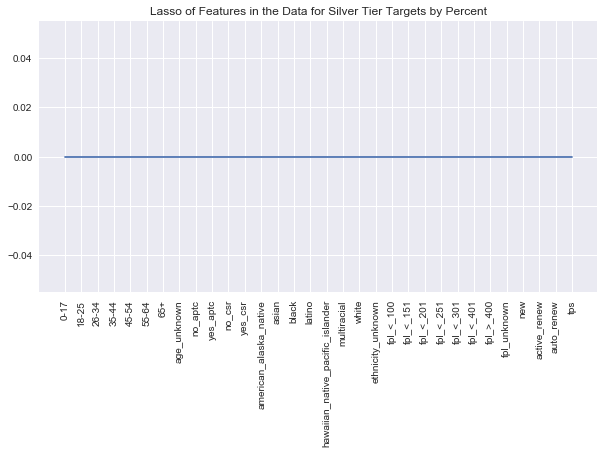

In [43]:
# Plot important features to predictive model using Lasso.
X_dfap = dfap.drop(['cfc','state','county','platinum','gold','silver','bronze','catastrophic', 'Year'], axis=1)
cols = X_dfap.columns

# Instantiate and fit Lasso model and calculate the coeffecient.
lasso = Lasso(alpha=.5, normalize=True)
lasso.fit(Xap,ysilap)
lasso_coef = lasso.coef_

# Plot the Lasso coeffecients for each feature.
fig, ax = plt.subplots(1,1, figsize=(10,5))
_ = ax.plot(range(len(cols)),lasso_coef)
_ = plt.xticks(range(len(cols)),cols.values, rotation=90)
_ = plt.title('Lasso of Features in the Data for Silver Tier Targets by Percent')
plt.show()

In [44]:
# Time to tune the alpha of our Lasso Model.

#Instantiate Lasso Regressor and initiate name start point.
lasso = Lasso()
place = 0

# Create hyperparameter grid for alpha
alpha = [.0001,.001,.01,.1,1,10,100]
a_grid = {'alpha': alpha}

#Set up GridSearchCV object.
grid_cv = GridSearchCV(lasso, a_grid, cv=5)

# Iterate over metallic tiers and prine best alpha for each tier
for y in ysap:
    X_train, X_test, y_train, y_test = train_test_split(Xap,y, test_size=.3, random_state=42)
    
    # Fit training data
    grid_cv.fit(X_train,y_train)
    
    # Predict on the test set and compute metrics
    y_pred = grid_cv.predict(X_test)
    r2 = grid_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print(ys_name[place],"Tuned Lasso alpha ratio: {}".format(grid_cv.best_params_))
    print(ys_name[place],"Tuned Lasso R^2: {}".format(r2))
    print(ys_name[place],"Tuned Lasso MSE: {}".format(mse),'\n')
    place+=1

Catastrophic Tuned Lasso alpha ratio: {'alpha': 0.0001}
Catastrophic Tuned Lasso R^2: 0.08707043433137429
Catastrophic Tuned Lasso MSE: 4.634460089247199e-05 

Bronze Tuned Lasso alpha ratio: {'alpha': 0.0001}
Bronze Tuned Lasso R^2: 0.5867446977930734
Bronze Tuned Lasso MSE: 0.004036950554756207 

Silver Tuned Lasso alpha ratio: {'alpha': 0.0001}
Silver Tuned Lasso R^2: 0.8748053618701193
Silver Tuned Lasso MSE: 0.0012303199551856453 

Gold Tuned Lasso alpha ratio: {'alpha': 0.0001}
Gold Tuned Lasso R^2: 0.2022415302179914
Gold Tuned Lasso MSE: 0.002497973229194961 

Platinum Tuned Lasso alpha ratio: {'alpha': 0.0001}
Platinum Tuned Lasso R^2: 0.052860784651262094
Platinum Tuned Lasso MSE: 0.00025992002081607837 



In [45]:
# Initialize Alphas, and Nameplace
lasso_alphas=[.0001,.0001,.0001,.0001,.0001]
place = 0

#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ysap:
    X_train, X_test, y_train, y_test = train_test_split(Xap,y, test_size=.3, random_state=42)
    lasso = Lasso(alpha=lasso_alphas[place])
    lasso.fit(X_train, y_train)
    pred = lasso.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    cv_scores = cross_val_score(lasso, Xap, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place +=1

Catastrophic Root Mean Squared Error: 0.006807686897358896
Catastrophic Average 5-Fold R^2: 0.03953987634628524 

Bronze Root Mean Squared Error: 0.06353700146179553
Bronze Average 5-Fold R^2: 0.5725086876249706 

Silver Root Mean Squared Error: 0.03507591702558388
Silver Average 5-Fold R^2: 0.8711687982146372 

Gold Root Mean Squared Error: 0.04997972818248375
Gold Average 5-Fold R^2: 0.13355516791615368 

Platinum Root Mean Squared Error: 0.01612203525663179
Platinum Average 5-Fold R^2: -0.43951398825136484 



In [46]:
# Initialize starting place.
place = 0
#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ysap:
    X_train, X_test, y_train, y_test = train_test_split(Xap,y, test_size=.3, random_state=42)
    
    # Scaling the data may help as variance is very high within the data.
    steps = [('scaler', StandardScaler()),('lasso', Lasso(alpha=lasso_alphas[place]))]
    # Create Pipeline and initialize starting place.
    pipe = Pipeline(steps)
    # Fit pipeline and calculate metrics. 
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    cv_scores = cross_val_score(pipe, Xap, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place +=1

Catastrophic Root Mean Squared Error: 0.006030920237437784
Catastrophic Average 5-Fold R^2: 0.2486586200062849 

Bronze Root Mean Squared Error: 0.06252698702622723
Bronze Average 5-Fold R^2: 0.583243867344835 

Silver Root Mean Squared Error: 0.033104385040966584
Silver Average 5-Fold R^2: 0.890869784987234 

Gold Root Mean Squared Error: 0.04894610890433959
Gold Average 5-Fold R^2: 0.09760579901923046 

Platinum Root Mean Squared Error: 0.0156063171334003
Platinum Average 5-Fold R^2: -0.4997171427291425 



***
## ElasticNet - All by Percent

In [47]:
# Time to tune the l1 ratio of our ElasticNet Model.

# Instantiate ElasticNet Regressor and initiate name start point.
enet = ElasticNet()
place = 0

# Create hyperparameter grid for alpha
l1_space = np.linspace(0,1.5,30)
grid = {'l1_ratio': l1_space}

#Set up GridSearchCV object.
grid_cv = GridSearchCV(enet, grid, cv=5)

# Iterate over metallic tiers and prine best alpha for each tier
for y in ysap:
    X_train, X_test, y_train, y_test = train_test_split(Xap,y, test_size=.3, random_state=42)
    
    # Fit training data
    grid_cv.fit(X_train,y_train)
    
    # Predict on the test set and compute metrics
    y_pred = grid_cv.predict(X_test)
    r2 = grid_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print(ys_name[place],"Tuned ElasticNet l1 ratio: {}".format(grid_cv.best_params_))
    print(ys_name[place],"Tuned ElasticNet R^2: {}".format(r2))
    print(ys_name[place],"Tuned ElasticNet MSE: {}".format(mse),'\n')
    place+=1

Catastrophic Tuned ElasticNet l1 ratio: {'l1_ratio': 0.0}
Catastrophic Tuned ElasticNet R^2: 0.026256087527187
Catastrophic Tuned ElasticNet MSE: 4.943182332141397e-05 

Bronze Tuned ElasticNet l1 ratio: {'l1_ratio': 0.0}
Bronze Tuned ElasticNet R^2: 0.024218462266931917
Bronze Tuned ElasticNet MSE: 0.00953207811015558 

Silver Tuned ElasticNet l1 ratio: {'l1_ratio': 0.0}
Silver Tuned ElasticNet R^2: 0.05989390379856463
Silver Tuned ElasticNet MSE: 0.009238664749750523 

Gold Tuned ElasticNet l1 ratio: {'l1_ratio': 0.0}
Gold Tuned ElasticNet R^2: 0.016287421266600766
Gold Tuned ElasticNet MSE: 0.0030802401729057636 

Platinum Tuned ElasticNet l1 ratio: {'l1_ratio': 0.0}
Platinum Tuned ElasticNet R^2: 0.024541454548955066
Platinum Tuned ElasticNet MSE: 0.000267691593094372 



In [48]:
# Initialize Alphas, Model, and Nameplace
enet_l1= [0, 0, 0, 0, 0]
place = 0

#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ysap:
    X_train, X_test, y_train, y_test = train_test_split(Xap,y, test_size=.3, random_state=42)
    enet = ElasticNet(l1_ratio= enet_l1[place])
    enet.fit(X_train, y_train)
    pred = enet.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    cv_scores = cross_val_score(enet, Xap, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place +=1

Catastrophic Root Mean Squared Error: 0.007030776864715162
Catastrophic Average 5-Fold R^2: 0.000695910398191147 

Bronze Root Mean Squared Error: 0.09763236200233803
Bronze Average 5-Fold R^2: 0.013471096253935277 

Silver Root Mean Squared Error: 0.09611797308386462
Silver Average 5-Fold R^2: 0.01787017609570083 

Gold Root Mean Squared Error: 0.05549991146754888
Gold Average 5-Fold R^2: 0.007643548249063392 

Platinum Root Mean Squared Error: 0.016361283357193345
Platinum Average 5-Fold R^2: -0.41708882852572293 



***
## Huber - All by Percent

In [49]:
# Tuning the alpha of the Huber Regresspr Model.

#Instantiate Huber Regressor and initiate place start point.
huber = HuberRegressor()
place = 0

# Create hyperparameter grid for alpha
alpha = [.0001,.001,.01,.1,1,10,100]
a_grid = {'alpha': alpha}

#Set up GridSearchCV object.
grid_cv = GridSearchCV(huber, a_grid, cv=5)

# Iterate over metallic tiers and prine best alpha for each tier
for y in ysap:
    X_train, X_test, y_train, y_test = train_test_split(Xap,y, test_size=.3, random_state=42)
    
    # Fit training data
    grid_cv.fit(X_train,y_train)
    
    # Predict on the test set and compute metrics
    y_pred = grid_cv.predict(X_test)
    r2 = grid_cv.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    print(ys_name[place],"Tuned Huber alpha ratio: {}".format(grid_cv.best_params_))
    print(ys_name[place],"Tuned Huber R^2: {}".format(r2))
    print(ys_name[place],"Tuned Huber MSE: {}".format(mse),'\n')
    place+=1

Catastrophic Tuned Huber alpha ratio: {'alpha': 10}
Catastrophic Tuned Huber R^2: -0.15788144023085438
Catastrophic Tuned Huber MSE: 5.877951075995454e-05 

Bronze Tuned Huber alpha ratio: {'alpha': 0.0001}
Bronze Tuned Huber R^2: 0.24026105753331375
Bronze Tuned Huber MSE: 0.007421631444005164 

Silver Tuned Huber alpha ratio: {'alpha': 0.01}
Silver Tuned Huber R^2: 0.5615712004659774
Silver Tuned Huber MSE: 0.004308552738777813 

Gold Tuned Huber alpha ratio: {'alpha': 0.01}
Gold Tuned Huber R^2: 0.09862176923350352
Gold Tuned Huber MSE: 0.0028224315693559376 

Platinum Tuned Huber alpha ratio: {'alpha': 0.1}
Platinum Tuned Huber R^2: -0.08347423848188207
Platinum Tuned Huber MSE: 0.0002973339526610181 



In [50]:
# Initialize Alphas, and Nameplace
huber_alphas=[10,.0001,.01,.01,.1]
place = 0

#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ysap:
    X_train, X_test, y_train, y_test = train_test_split(Xap,y, test_size=.3, random_state=42)
    huber = HuberRegressor(alpha=huber_alphas[place])
    huber.fit(X_train, y_train)
    pred = huber.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    cv_scores = cross_val_score(huber, Xap, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place +=1

Catastrophic Root Mean Squared Error: 0.00766677968641036
Catastrophic Average 5-Fold R^2: -0.30813582819567087 

Bronze Root Mean Squared Error: 0.08614889113624832
Bronze Average 5-Fold R^2: 0.1193060761898607 

Silver Root Mean Squared Error: 0.06563956686921245
Silver Average 5-Fold R^2: 0.4772143536628353 

Gold Root Mean Squared Error: 0.053126561806274814
Gold Average 5-Fold R^2: 0.01530869283148011 

Platinum Root Mean Squared Error: 0.017243374166937806
Platinum Average 5-Fold R^2: -0.14482746809242775 



In [51]:
# Initialize starting place for a scaled Huber Regressor
place = 0
#Iterate through target values, calculate and print RMSE, calculate and print Mean R^2 using 5-Fold CV
for y in ysap:
    X_train, X_test, y_train, y_test = train_test_split(Xap,y, test_size=.3, random_state=42)
    
    # Scaling the data may help as variance is very high within the data.
    steps = [('scaler', StandardScaler()),('huber', HuberRegressor(alpha=huber_alphas[place]))]
    # Create Pipeline and initialize starting place.
    pipe = Pipeline(steps)
    # Fit pipeline and calculate metrics. 
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(ys_name[place], 'Root Mean Squared Error: {}'.format(rmse))
    cv_scores = cross_val_score(pipe, Xap, y, cv=5)
    print(ys_name[place], 'Average 5-Fold R^2: {}'.format(np.mean(cv_scores)),'\n')
    place +=1

Catastrophic Root Mean Squared Error: 0.006818883860616319
Catastrophic Average 5-Fold R^2: -0.09016677211680568 

Bronze Root Mean Squared Error: 0.06324316481867924
Bronze Average 5-Fold R^2: 0.5796633035315573 

Silver Root Mean Squared Error: 0.03340170432436776
Silver Average 5-Fold R^2: 0.8836542342965817 

Gold Root Mean Squared Error: 0.05158671030374155
Gold Average 5-Fold R^2: 0.0726767884228908 

Platinum Root Mean Squared Error: 0.017334128454647595
Platinum Average 5-Fold R^2: -0.16745924686894523 



None of the models in the scaled data produced a R^2 close to the raw counts data.  Regardless, better models need to be found for the Platinum and Catastrophic tiers.  There may be a way to build a Multinomial Logistic Regression model, as well as building better preprocessing to the existing models, that could significantly increase our R^2.